![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning & AI

## Redes Convolucionales: Detección de objetos

### Contexto

Airbus se complace en desafiar a los Kagglers a construir un modelo que detecte todos los barcos en imágenes de satélite lo más rápidamente posible.

**¿Puedes encontrarlos incluso en imágenes con nubes o bruma?**

Esta es la historia: El tráfico marítimo crece rápidamente. Un mayor número de buques aumenta las posibilidades de que se produzcan infracciones en el mar, como accidentes navales devastadores para el medio ambiente, piratería, pesca ilegal, tráfico de drogas y movimiento ilegal de mercancías. Esto ha obligado a muchas organizaciones, desde organismos de protección del medio ambiente hasta compañías de seguros y autoridades gubernamentales nacionales, a vigilar más de cerca los mares abiertos.

Airbus ofrece servicios integrales de vigilancia marítima mediante la creación de una solución significativa para una amplia cobertura, detalles finos, vigilancia intensiva, reactividad de primera calidad y respuesta de interpretación. Combinando sus datos patentados con analistas altamente cualificados, ayudan al sector marítimo a aumentar sus conocimientos, anticiparse a las amenazas, activar alertas y mejorar la eficiencia en el mar.
 
Si están interesados en explorar más datos de Airbus, le invitamos a visitar OneAtlas Sandbox. Y para más información sobre las capacidades de vigilancia echen un vistazo a la página de Airbus Intelligence (https://intelligence.airbus.com/industries/maritime/)

Info de los datos en: https://www.kaggle.com/competitions/airbus-ship-detection

### Descripción

En este concurso, deberán localizar barcos en imágenes y colocar un segmento de cuadro delimitador alineado alrededor de los barcos que localice. Muchas imágenes no contienen barcos, y las que sí los contienen pueden ser múltiples. 

Los barcos dentro de una misma imagen y entre imágenes pueden diferir en tamaño (a veces significativamente) y estar situados en mar abierto, en muelles, puertos deportivos, etc.

Para esta métrica, los segmentos de objetos no pueden solaparse. Hubo un pequeño porcentaje de imágenes, tanto en el conjunto de imágenes de prueba como en el de entrenamiento, en las que se produjo un ligero solapamiento de segmentos de objetos cuando los barcos estaban directamente uno al lado del otro. Cualquier superposición de segmentos se eliminó ajustándolos a la codificación de fondo (es decir, sin barco). Por lo tanto, algunas imágenes tienen una verdad de fondo que puede ser un cuadro delimitador alineado con algunos píxeles eliminados de un borde del segmento. Estos pequeños ajustes tendrán un impacto mínimo en la puntuación, ya que ésta se evalúa sobre umbrales de solapamiento crecientes.

El archivo train_ship_segmentations.csv proporciona la verdad básica (en formato de codificación run-length [RLE]) para las imágenes de entrenamiento. Los archivos sample_submission contienen las imágenes de prueba.

### Librerías

In [1]:
#Plotting
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import label

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

#Utils
import os
import numpy as np
import pandas as pd
import random
from dataclasses import dataclass
from torchsummary import summary

Vamos a hacer un muestro del dataset original, pero primero veamos su composición original:

In [2]:
# Path to the directory you want to check
directory_path = ['./Data/train_v2', './Data/test_v2', './Data/train_v2_sampled', './Data/test_v2_sampled']

# List of common image file extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

# Loop through all files in the directory
for dir in directory_path:
    # Initialize a counter
    image_count = 0
    for file in os.listdir(dir):
        # Check if the file is an image
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
    print(f"Number of images in the directory {dir}: {image_count}")

Number of images in the directory ./Data/train_v2: 192556
Number of images in the directory ./Data/test_v2: 15606
Number of images in the directory ./Data/train_v2_sampled: 18000
Number of images in the directory ./Data/test_v2_sampled: 1460


In [3]:
df = pd.read_csv('./Data/filtered_train_ship_segmentations_v2.csv')

In [4]:
df

,ImageId,EncodedPixels
0,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
...,...,...
21578,ffec2d694.jpg,NaN
21579,ffed9001d.jpg,NaN
21580,fff9aa012.jpg,NaN
21581,fffdd2377.jpg,333603 7 334359 19 335120 26 335888 26 336656 ...


In [5]:
print(df.shape[0], 'masks found')
print(len(df['ImageId'].unique()), 'unique images found')

21583 masks found
18000 unique images found


Vamos a chequear las dimensiones de las imágenes:

In [6]:
# Path to your image file
image_path = f"./Data/train_v2/{df['ImageId'][0]}"

# Open the image
image = Image.open(image_path)

# Get the size of the image
width, height = image.size

# Get the mode of the image to determine the number of channels
mode = image.mode

# Map the common modes to the number of channels
channel_map = {
    '1': 1, # (1-bit pixels, black and white, stored with one pixel per byte)
    'L': 1, # (8-bit pixels, black and white)
    'P': 1, # (8-bit pixels, mapped to any other mode using a color palette)
    'RGB': 3, # (3x8-bit pixels, true color)
    'RGBA': 4, # (4x8-bit pixels, true color with transparency mask)
    'CMYK': 4, # (4x8-bit pixels, color separation)
    'YCbCr': 3, # (3x8-bit pixels, color video format)
    'LAB': 3, # (3x8-bit pixels, the L*a*b color space)
    'HSV': 3, # (3x8-bit pixels, Hue, Saturation, Value color space)
    'I': 1, # (32-bit signed integer pixels)
    'F': 1, # (32-bit floating point pixels)
}

# Get the number of channels
num_channels = channel_map.get(mode, 'Unknown')

# Print the size and number of channels
print(f"Image dimensions (W x H x C) : {width} x {height} x {num_channels}")

Image dimensions (W x H x C) : 768 x 768 x 3


Veamos alguna de las imágenes:

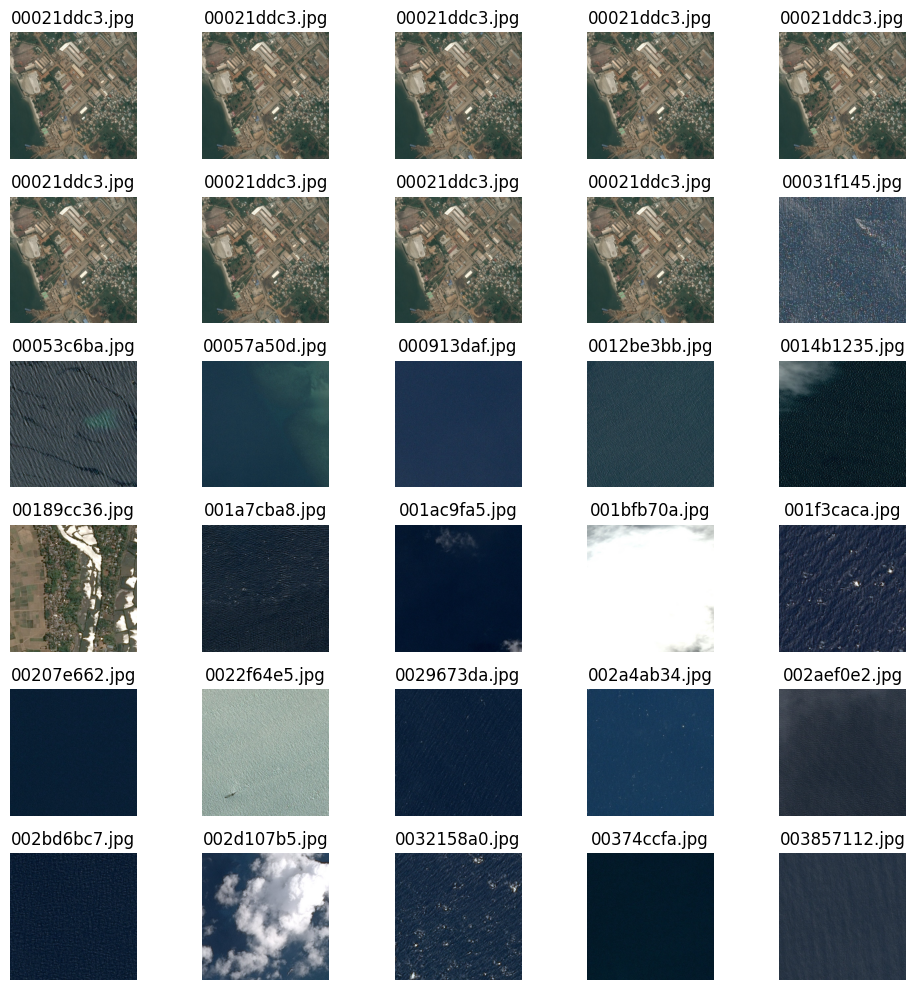

In [7]:
fig, axes = plt.subplots(6, 5, figsize=(10, 10))

# Flatten the array of axes to easily iterate over it
axes_flat = axes.flatten()

for i in range(30):
    image_id = df['ImageId'][i]
    image_path = f'./Data/train_v2_sampled/{image_id}'
    image = Image.open(image_path)
    axes_flat[i].imshow(image)
    axes_flat[i].axis('off')  # Hide the axes ticks
    axes_flat[i].set_title(image_id)

plt.tight_layout()
plt.show()

In [8]:
images_train = np.array(os.listdir('./Data/train_v2_sampled'))

In [9]:
marks = df[df['ImageId'].isin(images_train)]
marks

,ImageId,EncodedPixels
0,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
2,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
...,...,...
21578,ffec2d694.jpg,NaN
21579,ffed9001d.jpg,NaN
21580,fff9aa012.jpg,NaN
21581,fffdd2377.jpg,333603 7 334359 19 335120 26 335888 26 336656 ...


Veamos el enmascaramiento:

In [10]:
def mask_part(pic, width, height, num_channels):
    '''
    Decodes a single ship mask from RLE to a numpy matrix.
    
    Parameters:
    - pic: RLE string.
    - width: Image width.
    - height: Image height.
    - num_channels: Number of mask channels, intended to be 3 for RGB masks.
    
    Returns:
    - Numpy array of the mask, shaped (height, width, num_channels).
    '''
    back = np.zeros(width * height)  # Initialize a flat array for single-channel data
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        start = int(starts[i]) - 1
        end = start + int(lens[i])
        back[start:end] = 1
    single_channel_mask = np.reshape(back, (height, width))  # Reshape to 2D single-channel mask
    
    # Expand the single-channel mask to 3 channels
    if num_channels == 3:
        three_channel_mask = np.stack((single_channel_mask,)*3, axis=-1)
        return three_channel_mask
    else:
        # If num_channels is not 3, this would need to be adjusted accordingly
        return single_channel_mask[:, :, np.newaxis]  # Add a new axis for the single channel


In [11]:
def is_empty(key, marks_aux):
    '''
    Function that checks if there is a ship in an image.

    Parameters:
    - key: The ImageId for the image to check.
    - marks_aux: A DataFrame containing the ImageId and mask information.

    Returns:
    - True if the image contains no ships, False otherwise.
    '''
    df = marks_aux[marks_aux['ImageId'] == key].iloc[:,1]
    # Check for empty or NaN values explicitly
    if df.isnull().all() or (len(df) == 1 and pd.isnull(df.iloc[0])):
        return True
    else:
        return False


In [12]:
def masks_all(key, marks_aux, width, height, num_channels):
    '''
    Merges all ship masks for a given image into one mask.
    
    Parameters:
    - key: Image ID.
    - marks_aux: DataFrame with Image IDs and RLE mask strings.
    - width: Image width.
    - height: Image height.
    - num_channels: Number of mask channels.
    
    Returns:
    - Composite mask as a numpy array.
    '''
    df = marks_aux[marks_aux['ImageId'] == key].iloc[:,1]
    masks = np.zeros((height, width, num_channels))
    if is_empty(key, marks_aux):
        return masks
    else:
        for mask_rle in df.dropna():
            masks += mask_part(mask_rle, width, height, num_channels)
        # Ensure masks don't exceed binary values after summation
        masks = np.clip(masks, 0, 1)
        return np.transpose(masks, (1, 0, 2))


In [13]:
def draw(path, lista, marks, width, height, num_channels):
    num_images = len(lista)
    plt.figure(figsize=(10, 20))
    for i, image_id in enumerate(lista):
        # Images are located in './Data/train_v2_sampled/'
        img_path = f'{path}{image_id}'
        img = plt.imread(img_path)
        
        # Generate mask using masks_all with the specified dimensions
        mask = masks_all(image_id, marks, width, height, num_channels)
        
        # Plot image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {image_id}")

        # Assuming the mask returned by masks_all is correctly shaped, but adjust if needed
        # Plot mask
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(mask.squeeze(), cmap='gray')  # Use squeeze() to remove single-channel dimension for display
        plt.axis('off')
        plt.title(f"Mask for: {image_id}")

    plt.tight_layout()
    plt.show()

Randomly chosen images with corresponding masks


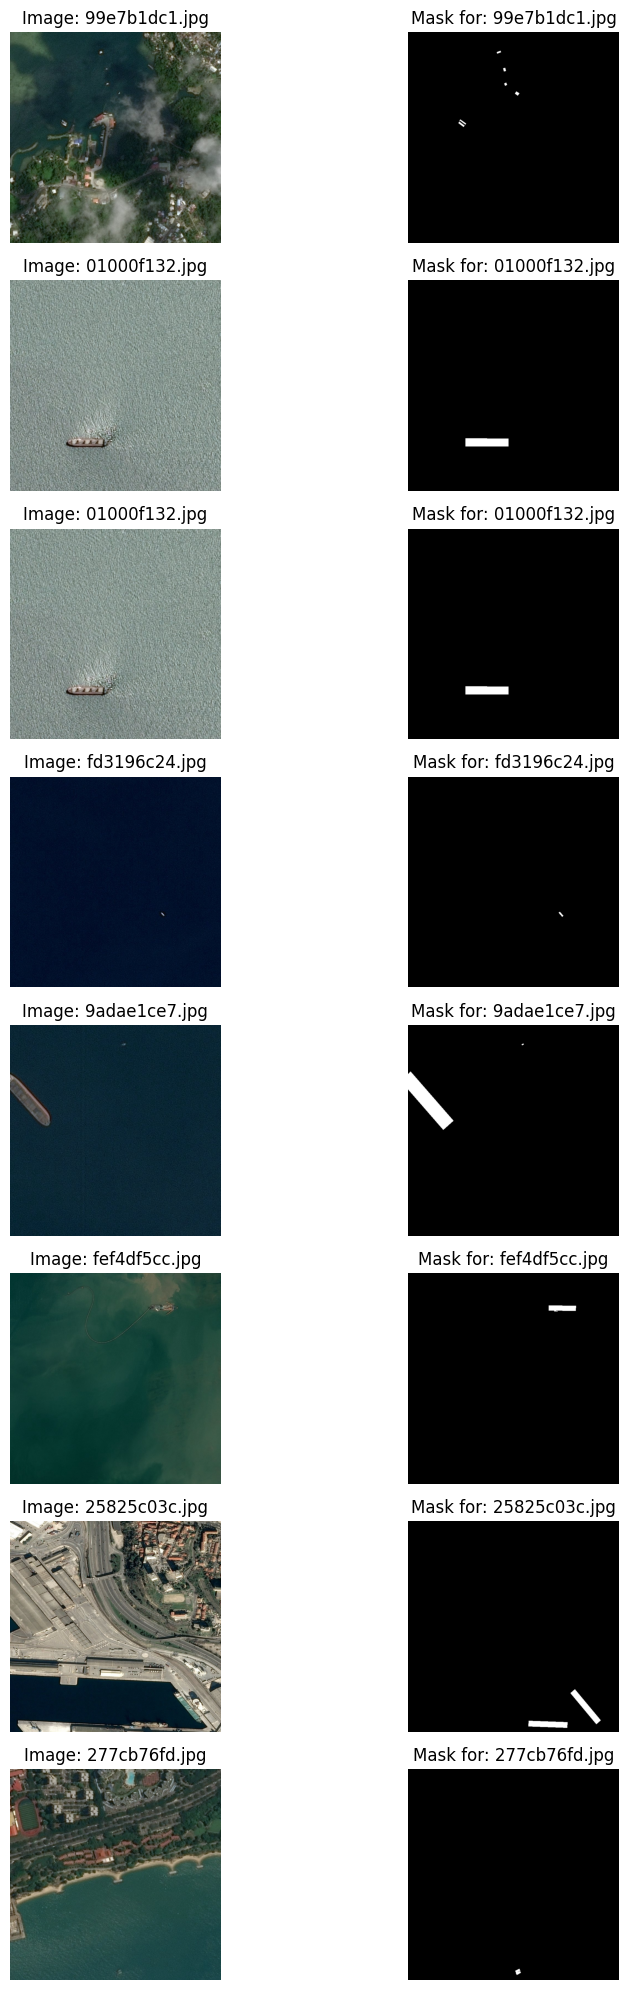

In [14]:
print('Randomly chosen images with corresponding masks')
draw('./Data/train_v2_sampled/', np.random.choice([i for i in images_train[:100] if not is_empty(i, marks)], size = 8), marks, width, height, num_channels)

### Modelo U-Net

Wiki: https://en.wikipedia.org/wiki/U-Net

Paper original: https://arxiv.org/abs/1505.04597

Arquictura U-Net:

![Colegio Bourbaki](./Images/UNet.png)

In [15]:
train_dpath = './Data/train_v2_sampled/'
test_dpath = './Data/test_v2_sampled/'
images_test = np.array(os.listdir(test_dpath))
original_img_size = (width, height)

In [16]:
@dataclass
class Params:
    img_size: tuple = (128, 128) # You can try with (256, 256)
    bs: int = 64
    num_workers: int = 4 #chequeo en foro y discusiones el paralelismo
    lr: float = 0.0001
    epochs: int = 10
    unet_depth: int = 4
    unet_start_filters: int = 16
    pin_memory: bool = False
    channel_means: tuple = (0.5, 0.5 , 0.5)
    channel_stds: tuple = (0.5, 0.5, 0.5)

In [17]:
def get_mask_encodings(annos, fnames):
    """
    Extracts run-length encoded masks for a specified set of images.

    Parameters:
    - annos: DataFrame containing 'ImageId' and 'EncodedPixels' columns.
    - fnames: Iterable of image filenames (IDs) to filter the annotations for.

    Returns:
    - Dictionary with image IDs as keys and lists of their mask encodings as values.
    """
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()

In [18]:
def rle_decode(mask_rle, shape=original_img_size):
    """
    Decodes a run-length encoded string into a binary mask.
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Shape is (height, width) and needs transpose to match image orientation


def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

In [19]:
class ImgDataset(Dataset):
    def __init__(self, img_dpath, img_fnames, img_transform, mask_encodings=None, mask_size=None, mask_transform=None):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        # Ensure transformations apply consistently between the image and its mask
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath).convert('RGB')  # Ensures consistency in image mode
        if self.img_transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)  # Ensure PyTorch transformations apply consistently
            img = self.img_transform(img)

        if self.mask_encodings is None:
            return img, fname

        # Improved NaN handling and check for empty mask encoding
        mask_enc = self.mask_encodings.get(fname, [])
        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if len(mask_enc) > 0 and not pd.isna(mask_enc[0]):
            for encoding in mask_enc:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(mask * 255)  # Convert to PIL Image for consistency with image transformations

        if self.mask_transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)

        # Convert mask to a PyTorch tensor directly if not already done by transformations
        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(np.array(mask, dtype=np.int64), dtype=torch.int64)

        return img, mask

    def __len__(self):
        return len(self.img_fnames)

In [20]:
train_tfms = transforms.Compose([transforms.Resize(Params.img_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(Params.channel_means, Params.channel_stds)])

test_tfms = transforms.Compose([transforms.Resize(Params.img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(Params.channel_means, Params.channel_stds)])

mask_tfms = transforms.Compose([transforms.Resize(Params.img_size),
                                transforms.ToTensor()])

In [21]:
train_dl = DataLoader(ImgDataset(train_dpath,
                                 images_train,
                                 train_tfms,
                                 get_mask_encodings(marks, images_train),
                                 original_img_size,
                                 mask_tfms),
                      batch_size=Params.bs,
                      pin_memory=Params.pin_memory,
                      num_workers=Params.num_workers,
                      shuffle=True
                      )

test_dl = DataLoader(ImgDataset(test_dpath,
                                images_test,
                                test_tfms),
                     batch_size=Params.bs,
                     pin_memory=Params.pin_memory,
                     num_workers=Params.num_workers,
                     shuffle=False)


In [22]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)
    
def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [23]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)
        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [24]:
class UNet(nn.Module):

    def __init__(self, num_classes, in_channels, depth,
                 start_filts, up_mode='transpose',
                 merge_mode='concat'):
  
        super(UNet, self).__init__()
        self._validate_up_mode(up_mode)
        self._validate_merge_mode(merge_mode)  
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth
        self.down_convs = []
        self.up_convs = []
        
        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth - 1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode, merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)
        self.reset_params()



    def _validate_up_mode(self, up_mode):
        if up_mode not in ('transpose', 'upsample'):
            raise ValueError(f"\"{up_mode}\" is not a valid mode for upsampling. Only \"transpose\" and \"upsample\" are allowed.")

    def _validate_merge_mode(self, merge_mode):
        if merge_mode not in ('concat', 'add'):
            raise ValueError(f"\"{merge_mode}\" is not a valid mode for merging up and down paths. Only \"concat\" and \"add\" are allowed.")

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        
        x = self.conv_final(x)
        # x = torch.sigmoid(x) # Use it for binary classification if you use BCELoss only
        # No softmax is used. This means you need to use nn.CrossEntropyLoss is your training script, as this module includes a softmax already.
        return x

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
model = UNet(num_classes=1,
             in_channels=3,
             depth=Params.unet_depth,
             start_filts=Params.unet_start_filters,
             merge_mode='concat')

model.to(device)

UNet(
  (conv_final): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stri

In [27]:
# Convert 'param.img_size' to the format expected by torchsummary, which is (channels, height, width)
input_size = (3, *Params.img_size)

summary(model, input_size, batch_size=Params.bs, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 128, 128]             448
            Conv2d-2         [64, 16, 128, 128]           2,320
         MaxPool2d-3           [64, 16, 64, 64]               0
          DownConv-4  [[-1, 16, 64, 64], [-1, 16, 128, 128]]               0
            Conv2d-5           [64, 32, 64, 64]           4,640
            Conv2d-6           [64, 32, 64, 64]           9,248
         MaxPool2d-7           [64, 32, 32, 32]               0
          DownConv-8  [[-1, 32, 32, 32], [-1, 32, 64, 64]]               0
            Conv2d-9           [64, 64, 32, 32]          18,496
           Conv2d-10           [64, 64, 32, 32]          36,928
        MaxPool2d-11           [64, 64, 16, 16]               0
         DownConv-12  [[-1, 64, 16, 16], [-1, 64, 32, 32]]               0
           Conv2d-13          [64, 128, 16, 16]          73,856
    

In [28]:
optim = torch.optim.Adam(model.parameters(), lr=Params.lr, amsgrad=True, weight_decay=0.1*Params.lr)
cost = nn.BCEWithLogitsLoss().to(device) # already activates with sigmoid inside
#cost = nn.BCELoss() # remeber to activate the last layer with sigmoid
#cost = nn.CrossEntropyLoss().to(device)

In [29]:
total_train_losses = []

model.train()
for epoch in range(Params.epochs):
    epoch_losses = []
    for i, (X, y) in enumerate(train_dl):
        optim.zero_grad(set_to_none=True)
        X, y = X.to(device), y.to(torch.float32).to(device)
        #Forward Pass
        outputs = model(X)
        loss = cost(outputs, y)
        #Backpropagation
        loss.backward()
        optim.step()

        if len(epoch_losses) == 0:
            torch.save(model.state_dict(), './Data/checkpoint.model')
        elif loss.item() < epoch_losses[-1]:
            torch.save(model.state_dict(), './Data/checkpoint.model')
        epoch_losses.append(loss.item())
    total_train_losses.append(sum(epoch_losses)/len(epoch_losses))
    print(f'| Epoch: {epoch} | Loss: {total_train_losses[-1]:.5f} |')  

| Epoch: 0 | Loss: 0.09967 |
| Epoch: 1 | Loss: 0.00805 |
| Epoch: 2 | Loss: 0.00679 |
| Epoch: 3 | Loss: 0.00545 |
| Epoch: 4 | Loss: 0.00408 |
| Epoch: 5 | Loss: 0.00372 |
| Epoch: 6 | Loss: 0.00360 |
| Epoch: 7 | Loss: 0.00344 |
| Epoch: 8 | Loss: 0.00330 |
| Epoch: 9 | Loss: 0.00331 |


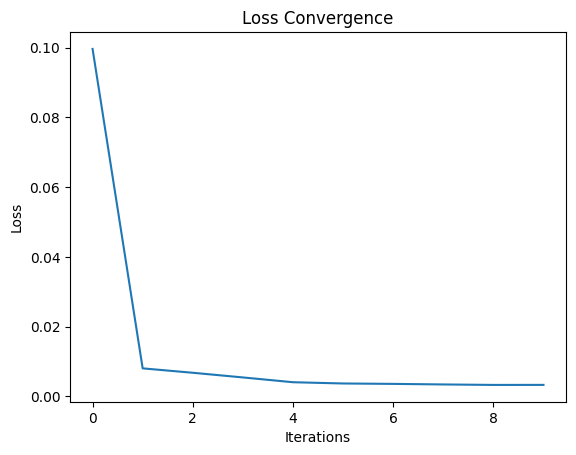

In [30]:
plt.plot(total_train_losses)
plt.title('Loss Convergence')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [31]:
bst_model_fpath = './Data/Model/bst_unet.model'
os.makedirs(os.path.dirname(bst_model_fpath), exist_ok=True)
torch.save(model.state_dict(), bst_model_fpath)

In [32]:
model_test = UNet(
            num_classes=1,
            in_channels=3,
            depth=Params.unet_depth,
            start_filts=Params.unet_start_filters,
            merge_mode='concat')

In [33]:
model_test.load_state_dict(torch.load('./Data/checkpoint.model'))
model_test.to(device)
model_test.eval() # change the model to evaluation mode to test

UNet(
  (conv_final): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stri

### Testing

In [34]:
submission = {'ImageId': [], 'EncodedPixels': []}

for X, fnames in test_dl:
    output = model_test(X.to(device))
    for i, fname in enumerate(fnames):
        mask = output[i]
        mask_sigmoid = torch.sigmoid(mask.squeeze())
        mask = (mask_sigmoid > 0.2)  # Thresholding to create a binary mask
        mask = Image.fromarray(mask.cpu().numpy().astype(np.uint8)).resize(original_img_size)
        mask = np.array(mask).astype(bool)
        labels = label(mask)  #`label` is imported correctly
        encodings = [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]
        if len(encodings) > 0:
            for encoding in encodings:
                submission['ImageId'].append(fname)
                submission['EncodedPixels'].append(encoding)
        else:
            submission['ImageId'].append(fname)
            submission['EncodedPixels'].append(None) 

In [35]:
submission_df = pd.DataFrame(submission, columns=['ImageId', 'EncodedPixels'])
#submission_df.to_csv('submission.csv', index=False)
submission_df

,ImageId,EncodedPixels
0,eb64dc514.jpg,None
1,fb5363f3a.jpg,None
2,9707edaad.jpg,None
3,70f9799bb.jpg,None
4,8a51199c5.jpg,None
...,...,...
1614,d7271a700.jpg,410700 12 411468 12 412236 12 413004 12 413772...
1615,64ba2411e.jpg,None
1616,a7eeada14.jpg,387438 6 388206 6 388974 6 389742 6 390510 6 3...
1617,a7eeada14.jpg,355206 6 355974 6 356742 6 357510 6 358278 6 3...


In [36]:
def draw_test(lista,marks_aux):
    l = int(len(lista)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(plt.imread('./Data/test_v2_sampled/'+lista[i]))
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        plt.imshow(masks_all(lista[i],marks_aux, width, height, num_channels)[:,:,0])
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()


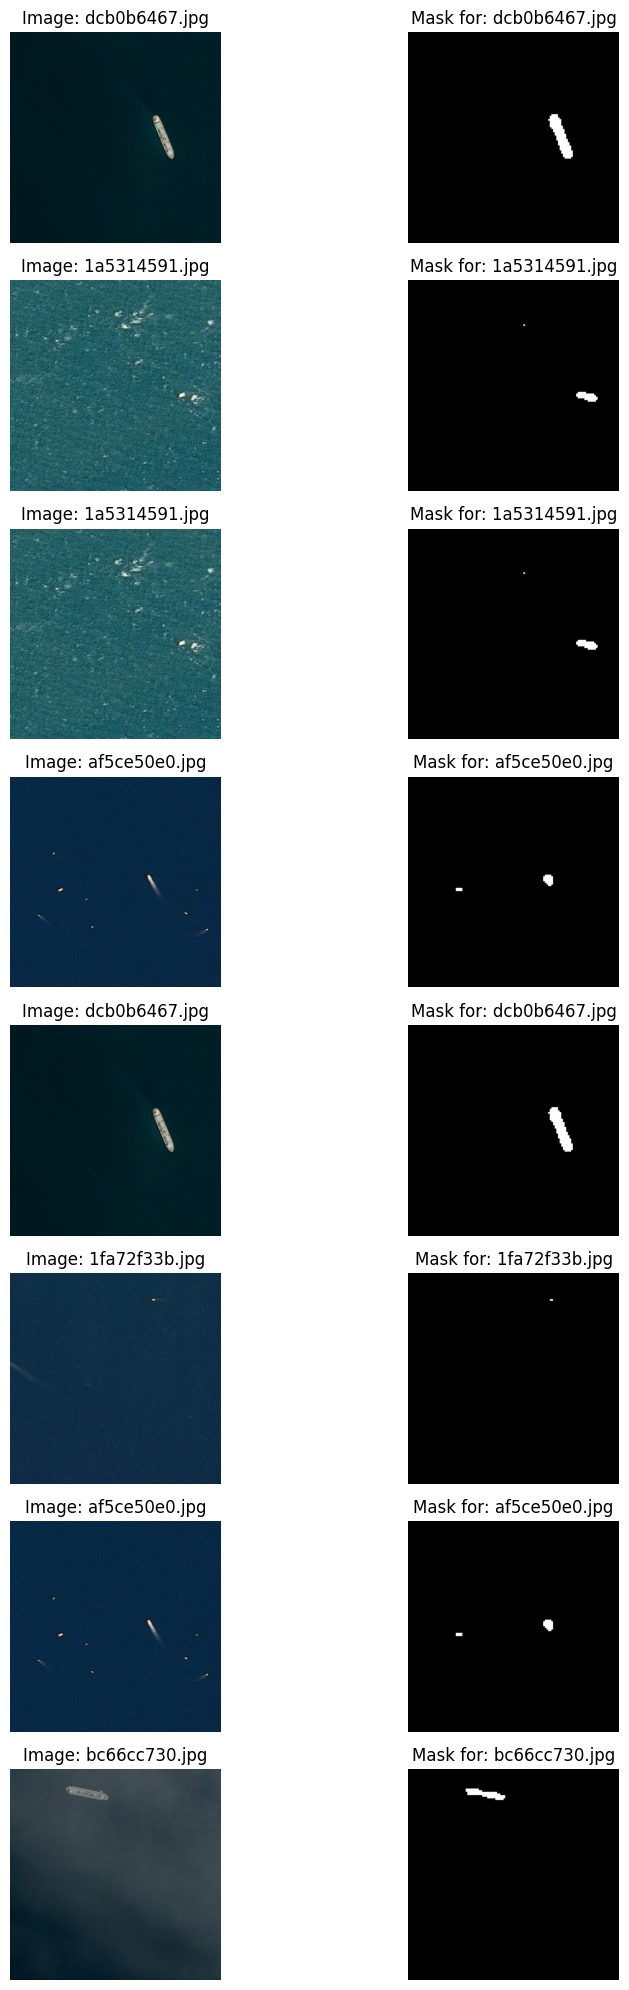

In [37]:
draw('./Data/test_v2_sampled/', np.random.choice([i for i in images_test[:100] if not is_empty(i, submission_df)], size = 8), submission_df, width, height, num_channels)

### Ejercicios:

Run-Length Encoding (RLE)

*¿Qué es Run-Length Encoding y para qué se utiliza?

* ¿Cómo se aplicaría RLE para comprimir la siguiente secuencia de píxeles: "AAAABBBCCDAA"?

* ¿Cuáles son las ventajas y desventajas de utilizar RLE en el contexto de la segmentación de imágenes?


Detección de Objetos

* Explica la diferencia entre la detección de objetos y la clasificación de imágenes.

* ¿Qué es un bounding box en el contexto de la detección de objetos?

* Menciona al menos dos métricas comunes utilizadas para evaluar modelos de detección de objetos.


U-Net

* Describe la estructura general de la arquitectura U-Net y su aplicación principal.
       
* ¿Cómo maneja U-Net el aprendizaje de características contextuales y locales?
    
* Proporciona un ejemplo de un problema que podría ser abordado eficazmente con U-Net fuera del ámbito médico.



Mejorar el modelo en caso de ser posible.

![Colegio Bourbaki](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)